# Factors that Influence Outcomes of the Five Domains of Speech-Language in Children with Hearing Loss at age 4 years

Paper 1

In [1]:
# Import modules and set options
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import arviz as az

sns.set(context='notebook', style='ticks')

Import data

In [2]:
lsl_dr = (pd.read_csv('../data/clean/lsl_dr.csv', index_col=0, low_memory=False)
                  .rename({'onset_1':'identify_mo'}, axis=1))

In [3]:
lsl_dr.head()

,redcap_event_name,academic_year_rv,hl,male,_race,prim_lang,sib,_mother_ed,father_ed,par1_ed,...,gf3_sis_ss,gf3_siw_ss,gf_version,ppvt_f,ppvt_ss,rowpvt_ss,school,score,test_name,test_type
0,initial_assessment_arm_1,2002.0,0.0,0.0,0.0,0.0,1.0,6.0,6.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,101,58.0,NaN,EOWPVT
1,initial_assessment_arm_1,2002.0,0.0,0.0,0.0,0.0,1.0,6.0,6.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,101,51.0,PLS,receptive
2,initial_assessment_arm_1,2002.0,0.0,0.0,0.0,0.0,1.0,6.0,6.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,101,60.0,PLS,expressive
3,initial_assessment_arm_1,2002.0,0.0,0.0,0.0,0.0,1.0,6.0,6.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,101,54.0,PLS,total
4,initial_assessment_arm_1,2011.0,0.0,1.0,3.0,0.0,1.0,5.0,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,626,96.0,NaN,EOWPVT


Indicator for non-profound hearing loss

In [4]:
lsl_dr['deg_hl_below6'] = lsl_dr.degree_hl<6
lsl_dr.loc[lsl_dr.degree_hl.isnull(), 'deg_hl_below6'] = np.nan

Indicator for first intervention outside OPTION

In [5]:
lsl_dr['int_outside_option'] = lsl_dr.age > lsl_dr.age_int
lsl_dr.loc[lsl_dr.age < lsl_dr.age_int, 'int_outside_option'] = np.nan

Indicator for high school graduation of mother

In [6]:
lsl_dr['mother_hs'] = lsl_dr.mother_ed > 1
lsl_dr.loc[lsl_dr.mother_ed.isnull(), 'mother_hs'] = None

Create age in years variable

In [7]:
lsl_dr['age_years'] = lsl_dr.age/12.

Create school index

In [8]:
schools_unique = np.sort(lsl_dr.school.unique())
school_lookup = dict(zip(schools_unique, range(len(schools_unique))))

In [9]:
lsl_dr['school_idx'] = lsl_dr.school.replace(school_lookup)

Create student index

In [10]:
student_unique = np.sort(lsl_dr.study_id.unique())
student_lookup = dict(zip(student_unique, range(len(student_unique))))

In [11]:
lsl_dr['student_idx'] = lsl_dr.study_id.replace(student_lookup)

In [12]:
age_mask = (lsl_dr.age_test>=48) & (lsl_dr.age_test<60)
lsl_dr.drop_duplicates('student_idx').shape

(6111, 252)

### Exclusions

Drop non-english and other disabilities, filter for hearing loss

In [13]:
other_etiology = (lsl_dr[['etiology_3___2', 'etiology_3___4', 'etiology_3___5', 'etiology_3___6', 'etiology_3___9',
       'etiology_oth___1', 'etiology_oth___3', 'etiology_oth___4', 'etiology_oth___8', 'etiology_oth___9']]
                      .sum(1).astype(bool))

In [14]:
inclusion_mask = (~lsl_dr.non_english.astype(bool) 
                  & (lsl_dr.degree_hl!=0)
                  & ((lsl_dr.etiology_2==0)
                  | (lsl_dr.etiology_2.isnull() & ~other_etiology)))

In [15]:
covariates = ['score', 'student_idx', 'school_idx', 'male', 'sib', 'family_inv', 'race', 
              'age_test', 'premature_weeks', 'age_amp', 'parent_hl',
              'domain', 'deg_hl_below6', 'mother_hs', 'mother_college', 'age_years', 'test_type', 
              'time', 'bilateral_ci', 'one_or_both_parent_hl',
              'bilateral_ha', 'unilateral_ci', 'unilateral_ha', 
              'bimodal', 'assymetrical', 'age_int', 'autism']

In [16]:
hl_type_cols = lsl_dr.columns[lsl_dr.columns.str.contains('lateral')].values.tolist()

In [17]:
covariates += list(set(hl_type_cols))
covariates = list(set(covariates))

In [18]:
analysis_subset = lsl_dr.loc[inclusion_mask, covariates].copy().dropna(subset=['time'])
analysis_subset.shape

(13743, 53)

In [19]:
analysis_subset.drop_duplicates('student_idx').shape

(1354, 53)

In [20]:
analysis_subset[['bilateral_ci',
              'bilateral_ha', 'unilateral_ci', 'unilateral_ha', 'bimodal']].mean()

bilateral_ci     0.626810
bilateral_ha     0.216256
unilateral_ci    0.023344
unilateral_ha    0.030817
bimodal          0.070724
dtype: float64

In [21]:
analysis_subset['premature'] = (analysis_subset.premature_weeks>0).astype(float)
analysis_subset.loc[analysis_subset.premature_weeks.isnull(), 'premature'] = np.nan

Add expressive and receptive to langauge test domains

In [22]:
analysis_subset.loc[(analysis_subset.domain=='Language') & (analysis_subset.test_type=='receptive'), 
           'domain'] = 'Receptive Language'
analysis_subset.loc[(analysis_subset.domain=='Language') & (analysis_subset.test_type=='expressive'), 
           'domain'] = 'Expressive Language'

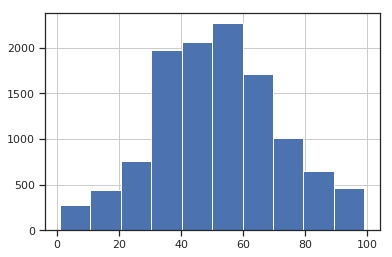

In [23]:
analysis_subset[analysis_subset.age_test<100].age_test.hist()

Drop records with missing race and age at ernollment, since there is less than 1% of them

In [24]:
analysis_subset = analysis_subset.dropna(subset=['race', 'age_years', 'age_test', 'parent_hl'])

In [25]:
analysis_subset.autism.sum()

5

## Covariate model specification

Student test scores were modeled across five domains: receptive language, expressive 
language, articulation, receptive vocabulary, and expressive vocabulary. Each domain was modeled separately, using the same general model structure, a Bayesian hierarchical mixed-effects linear model.

Consistent with the goals of the analysis, namely evaluating speech and language outcomes at 4 years of age, the subset of the dataset analyzed was restricted to children between the ages 48 and 60 months at the time of testing. Due to this age restriction, most students in the dataset contributed only one test score to the analysis, but several individuals (on the order of 100-200, depending on the test) contributed two or more. Rather than address the repeated measures (and resulting lack of independence) statistically, the mean test score was used for each student with more than one reported score within each domain.

Eight potential predictor variables (covariates) were included in the model as fixed effects, based on a priori expert opinion that considered them to be possibly influential for predicting test scores, and on the presence of reasonable variation in the predictor variable across subjects; variables that had identical values over a large portion of subjects were excluded. The final subset of covariates included gender, family involvement index, number of siblings in household, degree of hearing loss, mother’s education, age of enrollment, and time in the program. The family involvement scale is a 5-category ordinal variable that ranges from ideal participation by family (0) to limited participation (4) (Moeller, 2000). Mother’s education was coded as a binary variable that identifie children whose mother ha at least a high school diploma as the highest level of completed education. The degree of hearing loss was coded as a binary variable that took the value 1 if the degree of loss (based on PTA or ABR results) was less than 6 (profound), resulting in a variable that indicate non-profound hearing loss. Since degree of loss was considered important a priori, we wished to include it in the model, but the lack of variation among non-profound scores (<6) necessitated recoding into fewer categories. These variables were included together in a multivariate mixed effects model so that the estimates of each covariate effect re adjusted for the effects of the others. For example, the effect of decreased family involvement s the estimated effect after taking into account the other variables in the model.

In addition to the fixed effects specified above, we included a random effect to account for the variation in test scores among schools, over and above the variation explained by our variables of interest. This random effect estimates the mean and variance of the population of schools comprising this multi-center study. Hence, the predicted score for any particular student is a combination of the fixed effect predictors and the random effect from his or her school. The residual variation from the model is assumed to be normally distributed. 

The LSL-DR dataset includes several covariates of interest that have observations missing for some records. In order to avoid conducting complete case analysis, we imputed missing values using Bayesian statistical methods, which allows us to use all available data in our model (REF). We included covariates where one third were missing for the subset of data corresponding to a particular test. Missing values were imputed in the model by constructing distributions of values based on the non-missing values, and sampling from this distribution at every iteration of the Markov Chain Monte Carlo (MCMC) sampling procedure used to estimate the model. This approach assumes that covariate values are 
missing completely at random (MCAR). As an ad hoc measure for checking for obvious violations of this assumption, we calculated mean values for other variables according to whether each covariate was missing; if means differed strongly according to missingness, this would suggest that missingness may not be completely at random.

All models were estimated using Markov chain Monte Carlo (Brooks et al. 2011) methods. We specified vague priors to all unknown model parameters. Specifically, standard deviations of the random effects and the sampling distribution were given half-Cauchy priors with scale parameter set to 1, covariates were specified with zero-mean Gaussian priors with standard deviation 100, and the overall mean score also as Gaussian, but with a mean value of 100. Each model was run for 5000 iterations using the PyMC 3.5 software package (Salvatier et al. 2016), with 4000 iterations conservatively discarded as the burn-in interval, leaving 1000 for inference. Model convergence was checked by running a second MCMC chain, and calculating the Gelman-Rubin statistic (Gelman and Rubin 1992) using both chains. Model goodness-of-fit was evaluated using posterior predictive checks, by simulating mean outcome differences from the model and comparing the distribution of simulated differences to the observed mean difference. 

Utility function for filling NA values

In [26]:
def fillna(x, value):
    x_masked = np.ma.masked_invalid(x)
    np.ma.set_fill_value(x_masked, value)
    return x_masked

fillna(np.array([0.4, np.nan, 5]), 0.5)

masked_array(data=[0.4, --, 5.0],
             mask=[False,  True, False],
       fill_value=0.5)

Age of amplification appears to be a mixture, so I will impute it as such

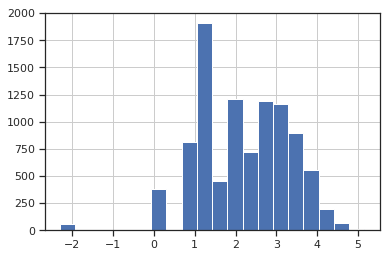

In [27]:
np.log(analysis_subset.age_amp+0.1).hist(bins=20)

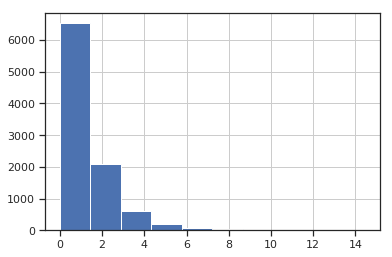

In [30]:
(analysis_subset.age_amp/12).hist()

In [ ]:
from pymc3 import Bernoulli, Normal, Uniform, Dirichlet, Categorical, Beta, HalfCauchy
from pymc3 import Gamma, Exponential, Multinomial, HalfNormal, NormalMixture, Lognormal
from pymc3 import Model, Deterministic, Metropolis
from numpy.ma import masked_values, set_fill_value, masked_invalid
import theano.tensor as tt
from theano import shared

def generate_model(dataset, cohort_age, intervention=False):
    
    if cohort_age==2:
        mask = (dataset.age_test>=24) & (dataset.age_test<36)
    elif cohort_age==3:
        mask = (dataset.age_test>=36) & (dataset.age_test<48)
    elif cohort_age==4:
        mask = (dataset.age_test>=48) & (dataset.age_test<60)
    elif cohort_age==5:
        mask = (dataset.age_test>=60) & (dataset.age_test<72)
    elif cohort_age==6:
        mask = (dataset.age_test>=72) & (dataset.age_test<84)
    else:
        print('Invalid age!')
        return
    
    # Generate mean scores
    mean_scores = dataset[mask].groupby('student_idx').score.mean()
    dataset_unique = dataset[mask].drop_duplicates(subset='student_idx')
    dataset_unique.set_index('student_idx').drop('score', axis=1).join(mean_scores)
    assert not dataset_unique.score.isnull().sum()
    
    (male, sib, family_inv, race, school, one_or_both_parent_hl, premature, time, 
             non_severe, mother_college, age_amp,
             age_enroll, age_int, score) = dataset_unique[['male', 'sib','family_inv', 
                                                           'race', 'school_idx', 
                                                  'one_or_both_parent_hl', 'premature',
                                                    'time', 'deg_hl_below6', 'mother_college', 
                                                    'age_amp', 'age_years', 
                                                    'age_int', 'score']].astype(float).T.values

    # Transform some data
    age_enroll_std = age_enroll - age_enroll.mean()

    with Model() as model:
        
        # Imputation of age of amplification
        if np.isnan(age_amp).sum():
            m_age_amp = Normal("m_age_amp", 0, sd=5, shape=2)
            s_age_amp = Exponential("s_age_amp", 1)
            p_age_amp = Beta('p_age_amp', 1, 1)
            _x_age_amp = NormalMixture('x_age_amp', [p_age_amp, 1-p_age_amp], m_age_amp, 
                                       sd=s_age_amp,
                                       observed=masked_invalid(np.log(age_amp+0.1)))
            x_age_amp = (tt.exp(_x_age_amp) - 0.1) / 12
        else:
            x_age_amp = age_amp / 12
        
        # Imputation of family involvement
        if np.isnan(family_inv).sum():
            p_family_inv = Dirichlet("p_family_inv", np.ones(5))
            x_family_inv = Categorical('x_family_inv', p_family_inv, 
                                       observed=masked_invalid(family_inv))
        else:
            x_family_inv = family_inv
        
        # Age of intervention
        if intervention and np.isnan(age_int).sum():
            m_int = Normal('m_int', 2, sd=5)
            s_int = HalfNormal('s_int', sd=5)
            x_age_int = Lognormal('x_premature', m_int, sd=s_int, observed=masked_invalid(age_int))
        else:
            x_age_int = age_int

        # Imputation of hearing loss
        if np.isnan(non_severe).sum():
            p_hl = Beta("p_hl", 1, 1, testval=0.9)
            x_hl = Bernoulli('x_hl', p_hl, observed=masked_invalid(non_severe))
        else:
            x_hl = non_severe
            
        # Imputation of parent hearing loss
        if np.isnan(one_or_both_parent_hl).sum():
            p_phl = Beta("p_phl", 1, 1)
            x_phl = Bernoulli('x_phl', p_phl, observed=masked_invalid(one_or_both_parent_hl))
        else:
            x_phl = one_or_both_parent_hl

        # Imputation of siblings
        if np.isnan(sib).sum():
            n_sib_cats = len(dataset.sib.unique())
            p_sib = Dirichlet("p_sib", np.ones(n_sib_cats))
            x_sib = Categorical('x_sib', p_sib, observed=masked_invalid(sib))
        else:
            x_sib = sib
            
        # Indices to school random effects
        unique_schools = np.unique(school)
        school_index = [list(unique_schools).index(s) for s in school]

        # School random effect (non-centered parameterization)
        μ_school = Normal('μ_school', 90, sd=10)
        σ_school = Exponential("σ_school", 1)
        z_school = Normal('z_school', mu=0, sd=1, shape=len(unique_schools))
        α_school = Deterministic("α_school", μ_school + z_school*σ_school)
        
        # Random intercepts
        intercept = α_school[school_index]
        
        # Race effect
        β_race = Normal("β_race", 0, sd=10, shape=4)
        race_effect = tt.concatenate([[0], β_race])[race.astype(int)]
        
        # Covariates
        X = [x_age_amp, 
             x_family_inv,
             x_sib, 
             x_hl, 
             mother_college, 
             x_phl, 
             age_enroll_std, 
             time]
        
        if intervention:
            X += [x_age_int]

        # Fixed effects
        β = Normal("β", 0, sd=100, shape=len(X))
        θ = intercept + race_effect + β.dot(tt.stack(X))
    
        σ = HalfNormal("σ", sd=25, testval=100)
        score_like = Normal("score_like", mu=θ, sd=σ, observed=score)

    return model

In [ ]:
receptive_language_dataset = analysis_subset[(analysis_subset.domain=='Receptive Language')]

In [ ]:
receptive_language_4 = generate_model(receptive_language_dataset, 4)

In [ ]:
iterations = 1000
tuning = 4000

In [ ]:
from pymc3 import sample

with receptive_language_4:
    
    rec_lang_4_trace = sample(iterations, 
                              tune=tuning, chains=2, cores=2)

In [34]:
labels = [#'Premature',           
          'Age at amplification',
          'Family Involvement Score', 
          'Sibling Count',
          'Non-profound Hearing Loss',
          'Mother with College Ed',
          'Parent with hearing loss',
          'Age at enrollment',
          'Years in program']

In [35]:
from pymc3 import traceplot, forestplot

In [36]:
x_range = -10, 15

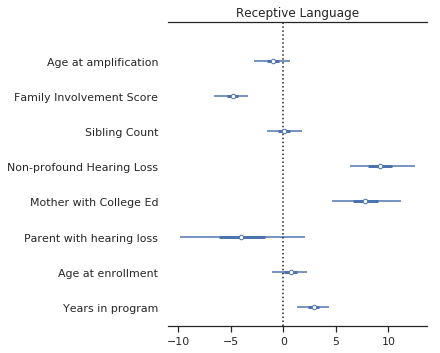

In [47]:
_,axes = az.plot_forest(rec_lang_4_trace, 
               var_names=['β'],
              combined=True)
axes[0].set_title('Receptive Language')
axes[0].vlines(0, *axes[0].get_ylim(), linestyles='dotted')
axes[0].set_yticklabels(labels[::-1]);

(<Figure size 432x792 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f35aa5d6d30>],
       dtype=object))

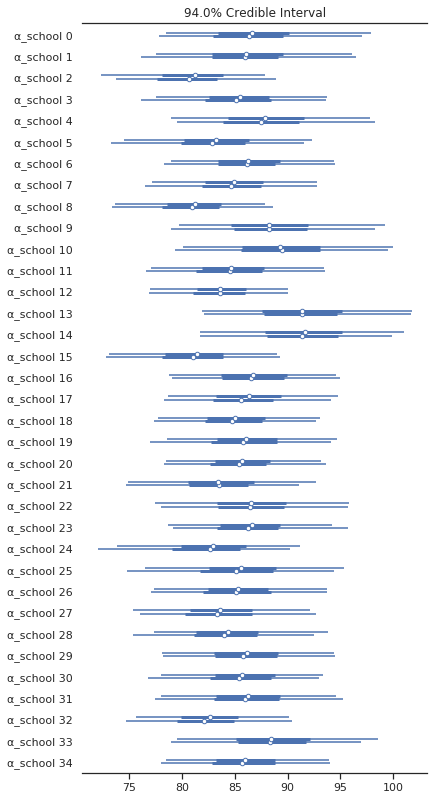

In [48]:
az.plot_forest(rec_lang_4_trace, var_names=['α_school'])

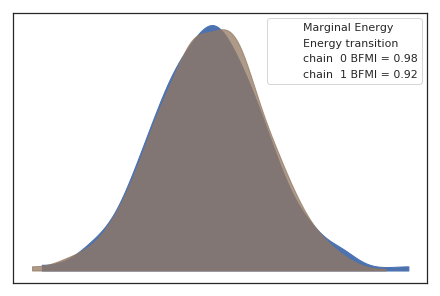

In [49]:
from pymc3 import energyplot

energyplot(rec_lang_4_trace)

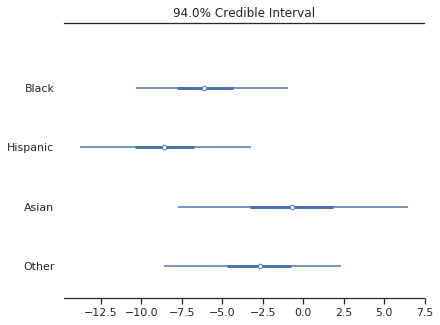

In [56]:
_, axes = az.plot_forest(rec_lang_4_trace, var_names=['β_race'], combined=True)
axes[0].set_yticklabels(['Black', 'Hispanic', 'Asian', 'Other'][::-1]);

The school random effect standard deviation is a measure of how variable scores are among schools. The estimated standard deviation is about 4 points for this domain.

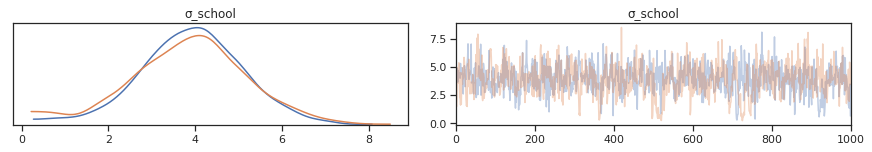

In [57]:
from pymc3 import traceplot

traceplot(rec_lang_4_trace, var_names=['σ_school']);

In [58]:
az.summary(rec_lang_4_trace, var_names=['β']).set_index(pd.Index(labels))

,mean,sd,mc error,hpd 3%,hpd 97%,ess,r_hat
Age at amplification,-0.97,0.91,0.03,-2.76,0.66,1367.0,1.0
Family Involvement Score,-4.80,0.84,0.02,-6.54,-3.31,1361.0,1.0
Sibling Count,0.09,0.87,0.02,-1.50,1.74,1742.0,1.0
Non-profound Hearing Loss,9.22,1.64,0.04,6.38,12.57,2293.0,1.0
Mother with College Ed,7.82,1.79,0.03,4.65,11.24,1605.0,1.0
Parent with hearing loss,-3.97,3.20,0.04,-9.86,2.09,2473.0,1.0
Age at enrollment,0.69,0.89,0.02,-1.09,2.26,1458.0,1.0
Years in program,2.90,0.83,0.02,1.27,4.36,870.0,1.0


## Expressive Language Model

In [59]:
expressive_language_dataset = analysis_subset[(analysis_subset.domain=='Expressive Language')]

In [60]:
expressive_language_4 = generate_model(expressive_language_dataset, 4)

/home/fonnesbeck_gmail_com/anaconda3/envs/dev/lib/python3.7/site-packages/pymc3/model.py:1330: UserWarning: Data in x_age_amp contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, UserWarning)
/home/fonnesbeck_gmail_com/anaconda3/envs/dev/lib/python3.7/site-packages/pymc3/model.py:1330: UserWarning: Data in x_family_inv contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, UserWarning)
/home/fonnesbeck_gmail_com/anaconda3/envs/dev/lib/python3.7/site-packages/pymc3/model.py:1330: UserWarning: Data in x_hl contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, UserWarning)
/home/fonnesbeck_gmail_com/anaconda3/envs/dev/lib/python3.7/site-packages/pymc3/model.py:1330: UserWarning: Data in x_phl contains missing values and will be automatically imputed from the sampling distribution.
  warni

In [61]:
with expressive_language_4:
    
    exp_lang_4_trace = sample(iterations, tune=tuning, cores=2)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [σ, β, β_race, z_school, σ_school, μ_school, p_sib, p_phl, p_hl, p_family_inv, x_age_amp_missing, p_age_amp, s_age_amp, m_age_amp]
>CategoricalGibbsMetropolis: [x_sib_missing, x_family_inv_missing]
>BinaryGibbsMetropolis: [x_hl_missing, x_phl_missing]
Sampling 2 chains: 100%|██████████| 10000/10000 [05:25<00:00, 30.70draws/s]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


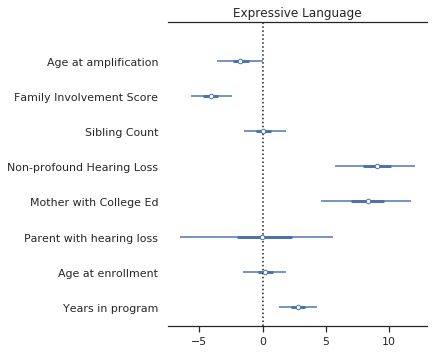

In [62]:
_,axes = az.plot_forest(exp_lang_4_trace, 
               var_names=['β'],
              combined=True)
axes[0].set_title('Expressive Language')
axes[0].vlines(0, *axes[0].get_ylim(), linestyles='dotted')
axes[0].set_yticklabels(labels[::-1]);

In [63]:
az.summary(exp_lang_4_trace, var_names=['β']).set_index(pd.Index(labels))

,mean,sd,mc error,hpd 3%,hpd 97%,ess,r_hat
Age at amplification,-1.76,0.95,0.03,-3.60,0.05,1046.0,1.0
Family Involvement Score,-4.09,0.87,0.01,-5.68,-2.43,1339.0,1.0
Sibling Count,0.09,0.91,0.02,-1.48,1.88,1653.0,1.0
Non-profound Hearing Loss,9.05,1.70,0.02,5.71,12.11,1765.0,1.0
Mother with College Ed,8.33,1.90,0.04,4.65,11.73,1439.0,1.0
Parent with hearing loss,0.09,3.26,0.07,-6.57,5.55,1483.0,1.0
Age at enrollment,0.21,0.93,0.02,-1.58,1.87,1125.0,1.0
Years in program,2.79,0.83,0.03,1.28,4.34,819.0,1.0


## Articulation Model

In [64]:
articulation_dataset = analysis_subset[(analysis_subset.domain=='Articulation')]

In [65]:
articulation_4 = generate_model(articulation_dataset, 4)

/home/fonnesbeck_gmail_com/anaconda3/envs/dev/lib/python3.7/site-packages/pymc3/model.py:1330: UserWarning: Data in x_age_amp contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, UserWarning)
/home/fonnesbeck_gmail_com/anaconda3/envs/dev/lib/python3.7/site-packages/pymc3/model.py:1330: UserWarning: Data in x_family_inv contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, UserWarning)
/home/fonnesbeck_gmail_com/anaconda3/envs/dev/lib/python3.7/site-packages/pymc3/model.py:1330: UserWarning: Data in x_hl contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, UserWarning)
/home/fonnesbeck_gmail_com/anaconda3/envs/dev/lib/python3.7/site-packages/pymc3/model.py:1330: UserWarning: Data in x_phl contains missing values and will be automatically imputed from the sampling distribution.
  warni

In [66]:
with articulation_4:
    
    artic_4_trace = sample(iterations, tune=tuning, cores=2)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [σ, β, β_race, z_school, σ_school, μ_school, p_sib, p_phl, p_hl, p_family_inv, x_age_amp_missing, p_age_amp, s_age_amp, m_age_amp]
>CategoricalGibbsMetropolis: [x_sib_missing, x_family_inv_missing]
>BinaryGibbsMetropolis: [x_hl_missing, x_phl_missing]
Sampling 2 chains: 100%|██████████| 10000/10000 [04:08<00:00, 40.24draws/s]
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


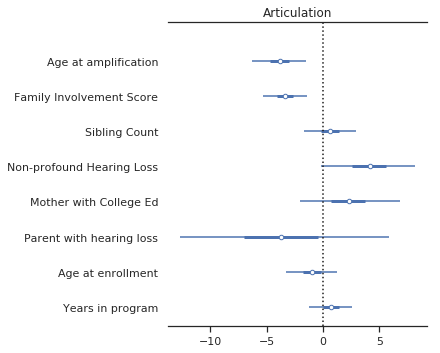

In [67]:
_,axes = az.plot_forest(artic_4_trace, 
               var_names=['β'],
              combined=True)
axes[0].set_title('Articulation')
axes[0].vlines(0, *axes[0].get_ylim(), linestyles='dotted')
axes[0].set_yticklabels(labels[::-1]);

In [68]:
az.summary(artic_4_trace, var_names=['β']).set_index(pd.Index(labels))

,mean,sd,mc error,hpd 3%,hpd 97%,ess,r_hat
Age at amplification,-3.82,1.29,0.05,-6.29,-1.47,1281.0,1.0
Family Involvement Score,-3.38,1.04,0.02,-5.28,-1.41,1236.0,1.0
Sibling Count,0.59,1.22,0.04,-1.68,2.95,831.0,1.0
Non-profound Hearing Loss,4.10,2.24,0.06,-0.17,8.19,1404.0,1.0
Mother with College Ed,2.23,2.36,0.08,-2.01,6.86,1339.0,1.0
Parent with hearing loss,-3.78,4.91,0.19,-12.71,5.83,1441.0,1.0
Age at enrollment,-0.99,1.21,0.03,-3.26,1.20,1422.0,1.0
Years in program,0.71,1.03,0.02,-1.23,2.56,1034.0,1.0


## Expressive Vocabulary Model

In [69]:
expressive_vocab_dataset = analysis_subset[(analysis_subset.domain=='Expressive Vocabulary')]

In [70]:
expressive_vocab_4 = generate_model(expressive_vocab_dataset, 4)

/home/fonnesbeck_gmail_com/anaconda3/envs/dev/lib/python3.7/site-packages/pymc3/model.py:1330: UserWarning: Data in x_age_amp contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, UserWarning)
/home/fonnesbeck_gmail_com/anaconda3/envs/dev/lib/python3.7/site-packages/pymc3/model.py:1330: UserWarning: Data in x_family_inv contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, UserWarning)
/home/fonnesbeck_gmail_com/anaconda3/envs/dev/lib/python3.7/site-packages/pymc3/model.py:1330: UserWarning: Data in x_hl contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, UserWarning)
/home/fonnesbeck_gmail_com/anaconda3/envs/dev/lib/python3.7/site-packages/pymc3/model.py:1330: UserWarning: Data in x_phl contains missing values and will be automatically imputed from the sampling distribution.
  warni

In [71]:
with expressive_vocab_4:
    
    expressive_vocab_4_trace = sample(iterations, tune=tuning, cores=2)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [σ, β, β_race, z_school, σ_school, μ_school, p_sib, p_phl, p_hl, p_family_inv, x_age_amp_missing, p_age_amp, s_age_amp, m_age_amp]
>CategoricalGibbsMetropolis: [x_sib_missing, x_family_inv_missing]
>BinaryGibbsMetropolis: [x_hl_missing, x_phl_missing]
Sampling 2 chains: 100%|██████████| 10000/10000 [05:40<00:00, 24.51draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


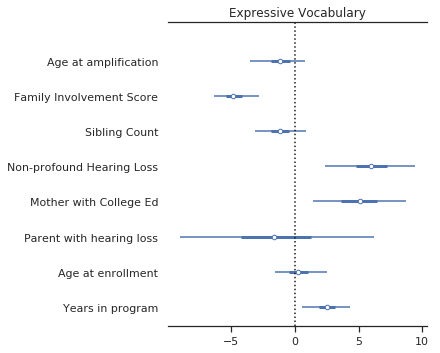

In [72]:
_,axes = az.plot_forest(expressive_vocab_4_trace, 
               var_names=['β'],
              combined=True)
axes[0].set_title('Expressive Vocabulary')
axes[0].vlines(0, *axes[0].get_ylim(), linestyles='dotted')
axes[0].set_yticklabels(labels[::-1]);

In [73]:
az.summary(expressive_vocab_4_trace, var_names=['β']).set_index(pd.Index(labels))

,mean,sd,mc error,hpd 3%,hpd 97%,ess,r_hat
Age at amplification,-1.12,1.14,0.02,-3.50,0.82,1168.0,1.0
Family Involvement Score,-4.77,0.93,0.02,-6.35,-2.84,1996.0,1.0
Sibling Count,-1.16,1.03,0.03,-3.13,0.84,1994.0,1.0
Non-profound Hearing Loss,6.00,1.88,0.02,2.39,9.46,2580.0,1.0
Mother with College Ed,5.07,2.01,0.04,1.39,8.73,1604.0,1.0
Parent with hearing loss,-1.55,4.07,0.05,-9.04,6.25,1804.0,1.0
Age at enrollment,0.27,1.08,0.03,-1.55,2.51,1203.0,1.0
Years in program,2.50,0.98,0.04,0.60,4.30,1169.0,1.0


## Receptive Vocabulary Model

In [74]:
receptive_vocab_dataset = analysis_subset[(analysis_subset.domain=='Receptive Vocabulary')]

In [75]:
receptive_vocab_4 = generate_model(receptive_vocab_dataset, 4)

/home/fonnesbeck_gmail_com/anaconda3/envs/dev/lib/python3.7/site-packages/pymc3/model.py:1330: UserWarning: Data in x_age_amp contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, UserWarning)
/home/fonnesbeck_gmail_com/anaconda3/envs/dev/lib/python3.7/site-packages/pymc3/model.py:1330: UserWarning: Data in x_family_inv contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, UserWarning)
/home/fonnesbeck_gmail_com/anaconda3/envs/dev/lib/python3.7/site-packages/pymc3/model.py:1330: UserWarning: Data in x_hl contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, UserWarning)
/home/fonnesbeck_gmail_com/anaconda3/envs/dev/lib/python3.7/site-packages/pymc3/model.py:1330: UserWarning: Data in x_phl contains missing values and will be automatically imputed from the sampling distribution.
  warni

In [76]:
with receptive_vocab_4:
    
    receptive_vocab_4_trace = sample(iterations, tune=tuning, cores=2)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [σ, β, β_race, z_school, σ_school, μ_school, p_sib, p_phl, p_hl, p_family_inv, x_age_amp_missing, p_age_amp, s_age_amp, m_age_amp]
>CategoricalGibbsMetropolis: [x_sib_missing, x_family_inv_missing]
>BinaryGibbsMetropolis: [x_hl_missing, x_phl_missing]
Sampling 2 chains: 100%|██████████| 10000/10000 [05:49<00:00, 15.93draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


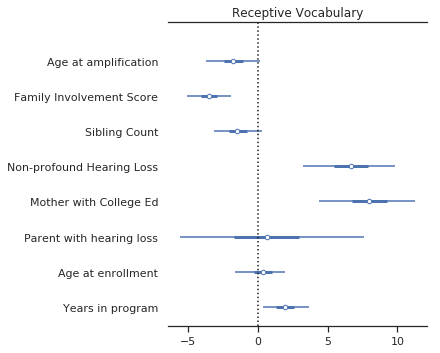

In [77]:
_,axes = az.plot_forest(receptive_vocab_4_trace, 
               var_names=['β'],
              combined=True)
axes[0].set_title('Receptive Vocabulary')
axes[0].vlines(0, *axes[0].get_ylim(), linestyles='dotted')
axes[0].set_yticklabels(labels[::-1]);

In [78]:
az.summary(receptive_vocab_4_trace, var_names=['β']).set_index(pd.Index(labels))

,mean,sd,mc error,hpd 3%,hpd 97%,ess,r_hat
Age at amplification,-1.73,1.03,0.02,-3.67,0.16,1086.0,1.0
Family Involvement Score,-3.48,0.86,0.03,-5.06,-1.90,1308.0,1.0
Sibling Count,-1.42,0.94,0.02,-3.15,0.34,1507.0,1.0
Non-profound Hearing Loss,6.65,1.80,0.03,3.27,9.85,2362.0,1.0
Mother with College Ed,8.05,1.84,0.03,4.42,11.29,1627.0,1.0
Parent with hearing loss,0.67,3.50,0.09,-5.58,7.63,1390.0,1.0
Age at enrollment,0.37,0.96,0.04,-1.63,1.98,1070.0,1.0
Years in program,1.93,0.88,0.03,0.39,3.65,777.0,1.0


In [79]:
from pymc3 import sample_posterior_predictive

with articulation_4:
    
    artic_4_pred = sample_posterior_predictive(artic_4_trace, vars=[articulation_4.score_like])

100%|██████████| 2000/2000 [00:05<00:00, 382.06it/s]


(array([129., 106., 114., 125., 141., 136., 128., 195., 166.,  52.]),
 array([0.   , 0.099, 0.198, 0.297, 0.396, 0.495, 0.594, 0.693, 0.792,
        0.891, 0.99 ]),
 <a list of 10 Patch objects>)

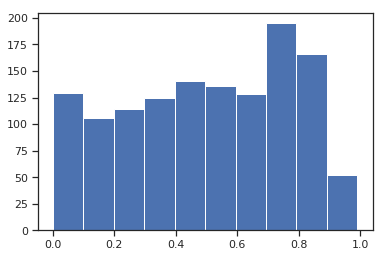

In [80]:
from scipy.stats import percentileofscore

plt.hist([np.round(percentileofscore(x, y)/100, 2) for x,y in zip(artic_4_pred['score_like'], 
                                                        articulation_dataset.score)])

### Publication graphics

/home/fonnesbeck_gmail_com/anaconda3/envs/dev/lib/python3.7/site-packages/matplotlib/_constrained_layout.py:226: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  warnings.warn('constrained_layout not applied.  At least '
/home/fonnesbeck_gmail_com/anaconda3/envs/dev/lib/python3.7/site-packages/matplotlib/_constrained_layout.py:226: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  warnings.warn('constrained_layout not applied.  At least '
/home/fonnesbeck_gmail_com/anaconda3/envs/dev/lib/python3.7/site-packages/matplotlib/_constrained_layout.py:226: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  warnings.warn('constrained_layout not applied.  At least '
/home/fonnesbeck_gmail_com/anaconda3/envs/dev/lib/python3.7/site-packages/matplotlib/_constrained_layout.py:226: UserWarning: constrained_layout not applied.  At least one axes coll

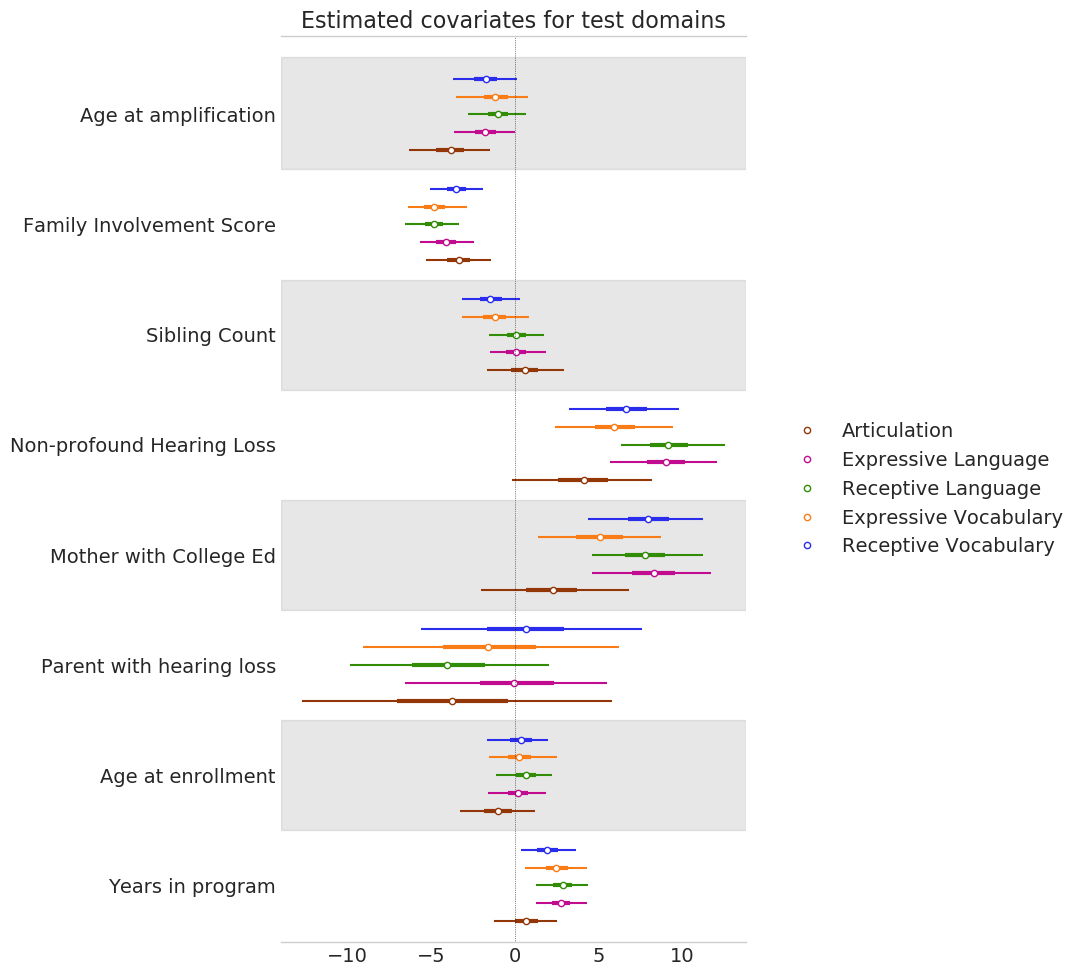

In [116]:
import arviz as az

az.style.use('arviz-whitegrid')


model_names = ['Receptive Vocabulary', 'Expressive Vocabulary',
                                     'Receptive Language', 'Expressive Language',
                                     'Articulation']

_, axes = az.plot_forest([receptive_vocab_4_trace, expressive_vocab_4_trace,
                         rec_lang_4_trace, exp_lang_4_trace, artic_4_trace],
                         model_names=model_names,
                         combined=True,
                         var_names=['β'])
axes[0].set_title('Estimated covariates for test domains')

axes[0].axvline(linestyle=":", linewidth=0.5, color='k')

ticklabels = [labels[int((i-2)/5)] if not (i % 5 - 2) else '' for i,label in enumerate(axes[0].get_yticklabels())][::-1]
axes[0].set_yticklabels(ticklabels)

lines = axes[0].get_lines()[:6:]
axes[0].legend(lines, model_names[::-1], loc='center right',  bbox_to_anchor=(1.72, 0.5),
          fancybox=True);